# Workgroup 4

Authors: Valerie Dube, Erzo Garay, Juan Marcos Guerrero y Matias Villalba

## Bootstraping

In [ ]:
install.packages("boot")

In [51]:
library(boot)

## Data base

The data is not created randomly; it is extracted from the "penn_jae.dat" database. This database is imported and filtered so that the variable "tg" becomes "t4," which is a dummy variable identifying those treated with t4 versus individuals in the control group.

In [ ]:
Penn <- as.data.frame(read.table("../../../data/penn_jae.dat", header=T ))
Penn<- subset(Penn, tg==4 | tg==0)
Penn$t4 <- ifelse(Penn$tg == 4, 1, Penn$tg)
Penn$tg <- NULL
attach(Penn)

## Bootstrap function

A function is created with the specified linear regression "log(inuidur1)~t4+ (female+black+othrace+factor(dep)+q2+q3+q4+q5+q6+agelt35+agegt54+durable+lusd+husd)," which outputs information about the estimated coefficients.


In [53]:
bootpar.fn <- function(data, index)
  coef(lm(log(inuidur1)~t4+ (female+black+othrace+factor(dep)+q2+q3+q4+q5+q6+agelt35+agegt54+durable+lusd+husd), data = data, subset = index))

In [82]:
reg_lineal = boot(Penn, bootpar.fn, 1000)

## Standard error

A table is created for the three specified variables: "t4", "female", and "black". Then, the distributions of the estimated parameters for the 1000 iterations are plotted.

In [93]:
original_values <- c(reg_lineal$t0[2], reg_lineal$t0[3], reg_lineal$t0[4])
standard_errors <- c(sd(reg_lineal$t[,2]),sd(reg_lineal$t[,3]), sd(reg_lineal$t[,4]))
table_data <- data.frame(
  "Original" = original_values,
  "Standard Error" = standard_errors
)
print(table_data)


          Original Standard.Error
t4     -0.07169248     0.03557456
female  0.12636833     0.03516956
black  -0.29376798     0.06033968


### t4 distribution

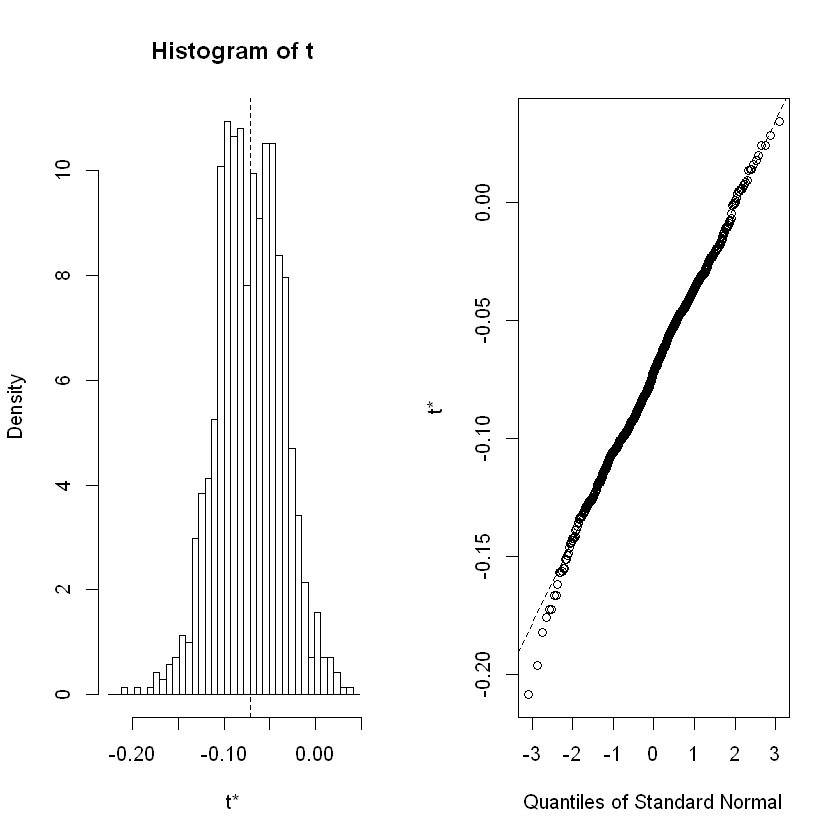

In [96]:
plot(reg_lineal, index=2) 

### Female distribution

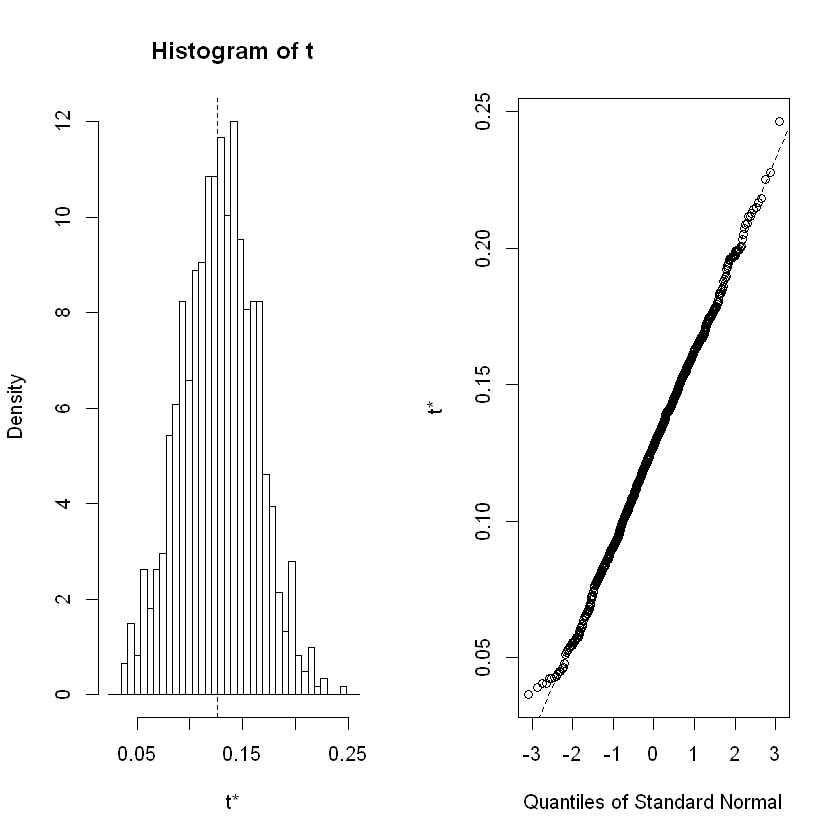

In [84]:
plot(reg_lineal, index=3) 

### Black distribution

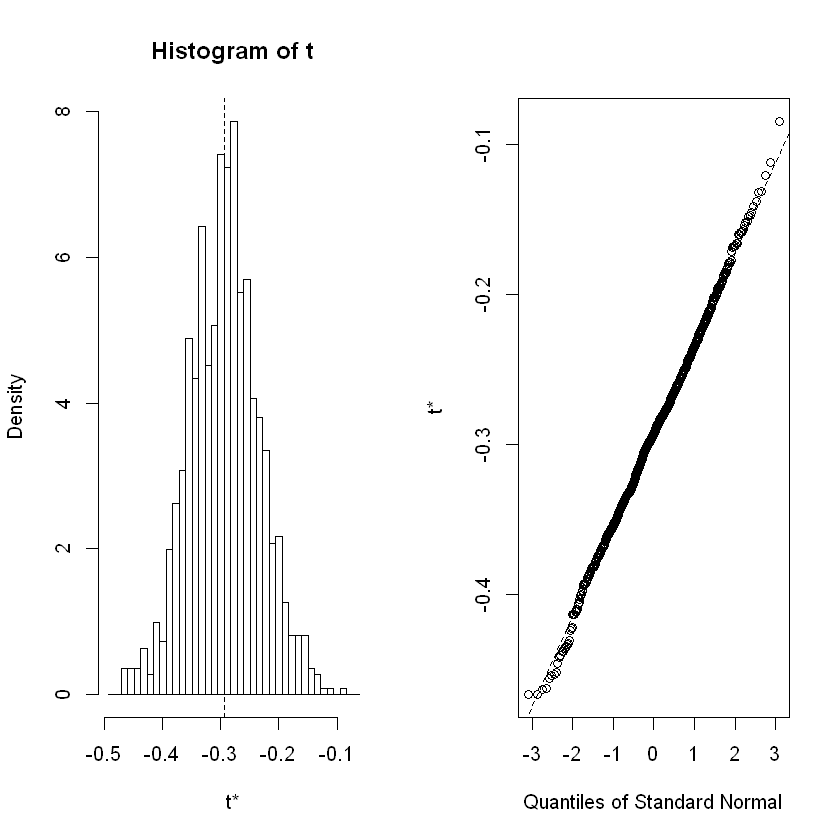

In [85]:
plot(reg_lineal, index=4) 

## Causal Forest

In [6]:
set.seed(1)

rm(list = ls())

library(grf)
if(packageVersion("grf") < '0.10.2') {
  warning("This script requires grf 0.10.2 or higher")
}
library(sandwich)
library(lmtest)
library(Hmisc)
library(ggplot2)

In [8]:
data.all = read.csv("../../data/synthetic_data.csv")
data.all$schoolid = factor(data.all$schoolid)

In [10]:
DF = data.all[,-1]
school.id = as.numeric(data.all$schoolid)

school.mat = model.matrix(~ schoolid + 0, data = data.all)
school.size = colSums(school.mat)

In [11]:
# It appears that school ID does not affect pscore. So ignore it
# in modeling, and just treat it as source of per-cluster error.
w.lm = glm(Z ~ ., data = data.all[,-3], family = binomial)
summary(w.lm)


Call:
glm(formula = Z ~ ., family = binomial, data = data.all[, -3])

Coefficients: (6 not defined because of singularities)
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.9524636  0.2845173  -3.348 0.000815 ***
schoolid2    0.0697302  0.2766287   0.252 0.800986    
schoolid3    0.0382080  0.2911323   0.131 0.895586    
schoolid4    0.1761334  0.2784711   0.633 0.527059    
schoolid5   -0.0033389  0.2950180  -0.011 0.990970    
schoolid6    0.0583548  0.3067481   0.190 0.849124    
schoolid7   -0.1313759  0.3188190  -0.412 0.680288    
schoolid8    0.1233661  0.3023736   0.408 0.683279    
schoolid9   -0.1955428  0.3073344  -0.636 0.524611    
schoolid10  -0.1892794  0.2968750  -0.638 0.523752    
schoolid11  -0.2224060  0.5461005  -0.407 0.683816    
schoolid12  -0.3312420  0.5414374  -0.612 0.540682    
schoolid13  -0.0408540  0.3989507  -0.102 0.918436    
schoolid14  -0.8681934  0.6033674  -1.439 0.150175    
schoolid15  -0.1059135  0.3263162  -0.325 0.74550

In [12]:
W = DF$Z
Y = DF$Y
X.raw = DF[,-(1:2)]

C1.exp = model.matrix(~ factor(X.raw$C1) + 0)
XC.exp = model.matrix(~ factor(X.raw$XC) + 0)

X = cbind(X.raw[,-which(names(X.raw) %in% c("C1", "XC"))], C1.exp, XC.exp)


In [13]:
#
# Grow a forest. Add extra trees for the causal forest.
#

Y.forest = regression_forest(X, Y, clusters = school.id, equalize.cluster.weights = TRUE)
Y.hat = predict(Y.forest)$predictions
W.forest = regression_forest(X, W, clusters = school.id, equalize.cluster.weights = TRUE)
W.hat = predict(W.forest)$predictions

cf.raw = causal_forest(X, Y, W,
                       Y.hat = Y.hat, W.hat = W.hat,
                       clusters = school.id,
                       equalize.cluster.weights = TRUE)
varimp = variable_importance(cf.raw)
selected.idx = which(varimp > mean(varimp))

cf = causal_forest(X[,selected.idx], Y, W,
                   Y.hat = Y.hat, W.hat = W.hat,
                   clusters = school.id,
                   equalize.cluster.weights = TRUE,
                   tune.parameters = "all")
tau.hat = predict(cf)$predictions

In [14]:
#
# Estimate ATE
#

ATE = average_treatment_effect(cf)
paste("95% CI for the ATE:", round(ATE[1], 3),
      "+/-", round(qnorm(0.975) * ATE[2], 3))

[1] "95% CI for the ATE: 0.247 +/- 0.039"

In [15]:
#
# Omnibus tests for heterogeneity
#

# Run best linear predictor analysis
test_calibration(cf)

# Compare regions with high and low estimated CATEs
high_effect = tau.hat > median(tau.hat)
ate.high = average_treatment_effect(cf, subset = high_effect)
ate.low = average_treatment_effect(cf, subset = !high_effect)
paste("95% CI for difference in ATE:",
      round(ate.high[1] - ate.low[1], 3), "+/-",
      round(qnorm(0.975) * sqrt(ate.high[2]^2 + ate.low[2]^2), 3))


Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value Pr(>t)    
mean.forest.prediction         1.006886   0.083618 12.0415 <2e-16 ***
differential.forest.prediction 0.292474   0.655626  0.4461 0.3278    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


[1] "95% CI for difference in ATE: 0.054 +/- 0.07"

In [16]:
#
# formal test for X1 and X2
#

dr.score = tau.hat + W / cf$W.hat *
  (Y - cf$Y.hat - (1 - cf$W.hat) * tau.hat) -
  (1 - W) / (1 - cf$W.hat) * (Y - cf$Y.hat + cf$W.hat * tau.hat)
school.score = t(school.mat) %*% dr.score / school.size

school.X1 = t(school.mat) %*% X$X1 / school.size
high.X1 = school.X1 > median(school.X1)
t.test(school.score[high.X1], school.score[!high.X1])

school.X2 = (t(school.mat) %*% X$X2) / school.size
high.X2 = school.X2 > median(school.X2)
t.test(school.score[high.X2], school.score[!high.X2])

school.X2.levels = cut(school.X2,
  breaks = c(-Inf, quantile(school.X2, c(1/3, 2/3)), Inf))
summary(aov(school.score ~ school.X2.levels))


	Welch Two Sample t-test

data:  school.score[high.X1] and school.score[!high.X1]
t = -3.0755, df = 71.824, p-value = 0.002972
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.19359639 -0.04132175
sample estimates:
mean of x mean of y 
0.1884369 0.3058960 



	Welch Two Sample t-test

data:  school.score[high.X2] and school.score[!high.X2]
t = 0.99875, df = 72.391, p-value = 0.3212
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.04006824  0.12054510
sample estimates:
mean of x mean of y 
0.2672857 0.2270472 


                 Df Sum Sq Mean Sq F value Pr(>F)
school.X2.levels  2 0.0826 0.04128   1.351  0.265
Residuals        73 2.2304 0.03055               


	One Sample t-test

data:  school.score.XS3.high - school.score.XS3.low
t = 2.2326, df = 75, p-value = 0.02856
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.009188917 0.161400046
sample estimates:
 mean of x 
0.08529448 


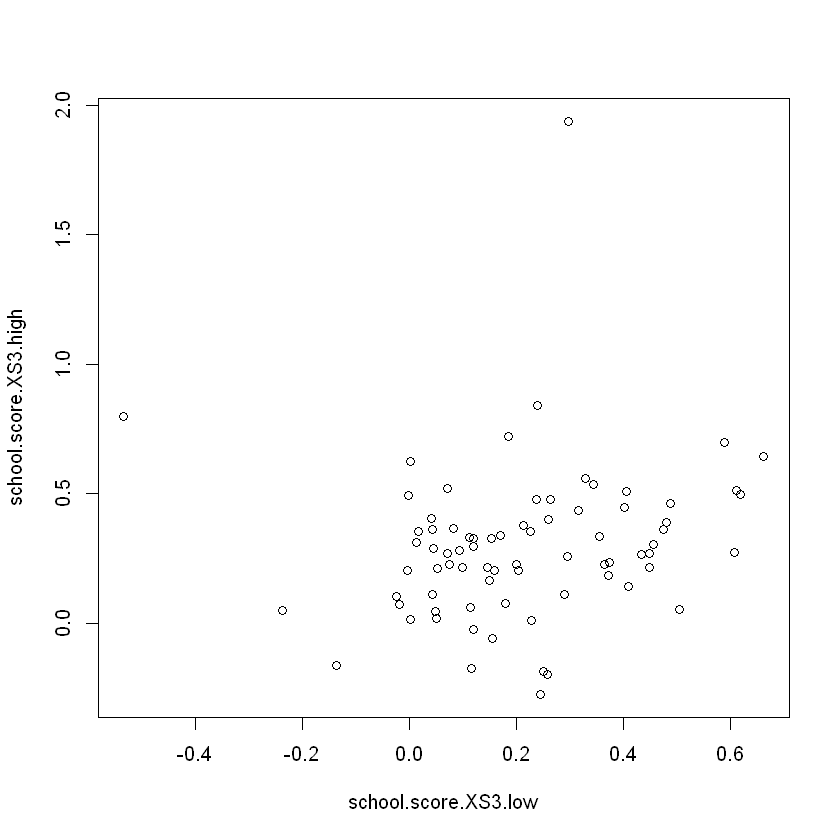

In [17]:
#
# formal test for S3
#

school.score.XS3.high = t(school.mat) %*% (dr.score * (X$S3 >= 6)) /
  t(school.mat) %*% (X$S3 >= 6)
school.score.XS3.low = t(school.mat) %*% (dr.score * (X$S3 < 6)) /
  t(school.mat) %*% (X$S3 < 6)

plot(school.score.XS3.low, school.score.XS3.high)
t.test(school.score.XS3.high - school.score.XS3.low)

In [18]:
#
# Look at school-wise heterogeneity
#

pdf("school_hist.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(school.score, xlab = "School Treatment Effect Estimate", main = "")
dev.off()


png 
  2

In [19]:
#
# Re-check ATE... sanity check only
#

ate.hat = mean(school.score)
se.hat = sqrt(var(school.score) / length(school.score - 1))
print(paste(round(ate.hat, 3), "+/-", round(1.96 * se.hat, 3)))

[1] "0.247 +/- 0.039"


In [20]:
#
# Look at variation in propensity scores
#

DF = X
DF$W.hat = cf$W.hat

pdf("pscore.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(W.hat ~ S3, data = DF, ylab = "Propensity Score", xlab = "Student Expectation of Success")
lines(smooth.spline(X$S3, cf$W.hat), lwd = 2, col = 4)
dev.off()

png 
  2

[1] "95% CI for the ATE: 0.253 +/- 0.022"


Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value  Pr(>t)    
mean.forest.prediction         1.007542   0.044966 22.4068 < 2e-16 ***
differential.forest.prediction 0.509010   0.123142  4.1335 1.8e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


[1] 1
[1] 2
[1] 3
[1] 4
[1] 5



Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value  Pr(>t)    
mean.forest.prediction         1.007637   0.065782  15.318 < 2e-16 ***
differential.forest.prediction 0.356911   0.229080   1.558 0.05963 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


[1] 0.0001137156 0.0003466146

                     Df Sum Sq Mean Sq F value   Pr(>F)    
factor(school.id)    75    200   2.673   1.989 8.85e-07 ***
Residuals         10315  13861   1.344                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

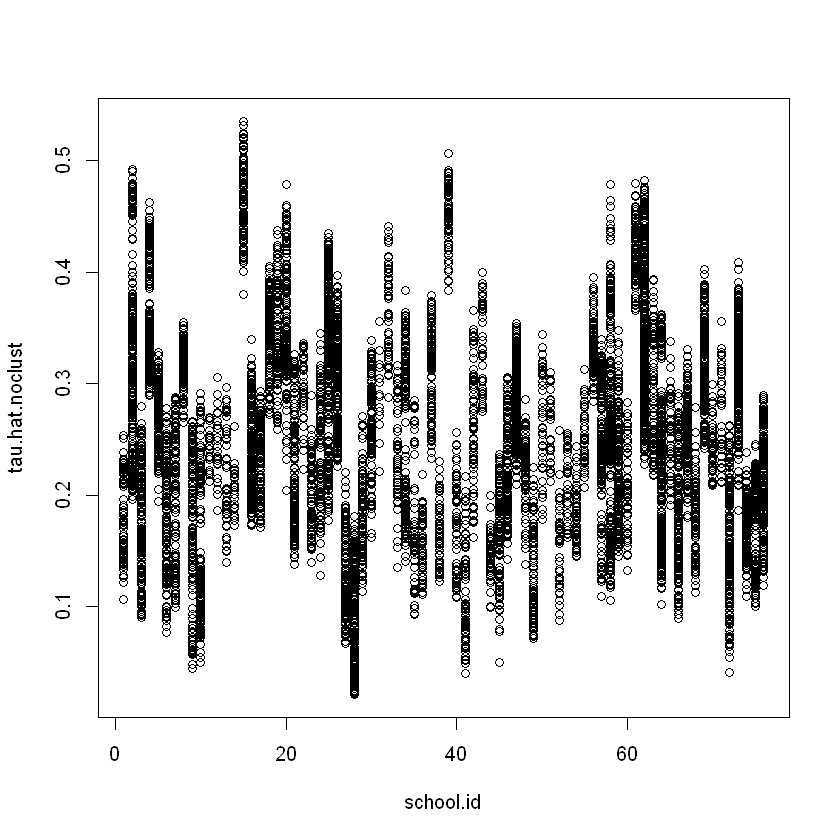

In [21]:
#
# Analysis ignoring clusters
#

cf.noclust = causal_forest(X[,selected.idx], Y, W,
                           Y.hat = Y.hat, W.hat = W.hat,
                           tune.parameters = "all")

ATE.noclust = average_treatment_effect(cf.noclust)
paste("95% CI for the ATE:", round(ATE.noclust[1], 3),
      "+/-", round(qnorm(0.975) * ATE.noclust[2], 3))

test_calibration(cf.noclust)

tau.hat.noclust = predict(cf.noclust)$predict
plot(school.id, tau.hat.noclust)

nfold = 5
school.levels = unique(school.id)
cluster.folds = sample.int(nfold, length(school.levels), replace = TRUE)

tau.hat.crossfold = rep(NA, length(Y))
for (foldid in 1:nfold) {
  print(foldid)
  infold = school.id %in% school.levels[cluster.folds == foldid]
  cf.fold = causal_forest(X[!infold, selected.idx], Y[!infold], W[!infold],
                          Y.hat = Y.hat[!infold], W.hat = W.hat[!infold],
                          tune.parameters = "all")
  pred.fold = predict(cf.fold, X[infold, selected.idx])$predictions
  tau.hat.crossfold[infold] = pred.fold
}

cf.noclust.cpy = cf.noclust
cf.noclust.cpy$predictions = tau.hat.crossfold
cf.noclust.cpy$clusters = school.id
test_calibration(cf.noclust.cpy)

Rloss = mean(((Y - Y.hat) - tau.hat * (W - W.hat))^2)
Rloss.noclust = mean(((Y - Y.hat) - tau.hat.noclust * (W - W.hat))^2)
Rloss.crossfold = mean(((Y - Y.hat) - tau.hat.crossfold * (W - W.hat))^2)

c(Rloss.noclust - Rloss, Rloss.crossfold - Rloss)

summary(aov(dr.score ~ factor(school.id)))

In [22]:
#
# Analaysis without fitting the propensity score
#

cf.noprop = causal_forest(X[,selected.idx], Y, W,
                          Y.hat = Y.hat, W.hat = mean(W),
                          tune.parameters = "all",
                          equalize.cluster.weights = TRUE,
                          clusters = school.id)
tau.hat.noprop = predict(cf.noprop)$predictions

ATE.noprop = average_treatment_effect(cf.noprop)
paste("95% CI for the ATE:", round(ATE.noprop[1], 3),
      "+/-", round(qnorm(0.975) * ATE.noprop[2], 3))

pdf("tauhat_noprop.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
plot(tau.hat, tau.hat.noprop,
     xlim = range(tau.hat, tau.hat.noprop),
     ylim = range(tau.hat, tau.hat.noprop),
     xlab = "orthogonalized causal forest estimates",
     ylab = "non-orthogonalized causal forest")
abline(0, 1, lwd = 2, lty = 2, col = 4)
par = pardef
dev.off()

[1] "95% CI for the ATE: 0.254 +/- 0.039"

png 
  2

In [23]:
#
# Train forest on school-wise DR scores
#

school.X = (t(school.mat) %*% as.matrix(X[,c(4:8, 25:28)])) / school.size
school.X = data.frame(school.X)
colnames(school.X) = c("X1", "X2", "X3", "X4", "X5",
                    "XC.1", "XC.2", "XC.3", "XC.4")

dr.score = tau.hat + W / cf$W.hat * (Y - cf$Y.hat - (1 - cf$W.hat) * tau.hat) -
  (1 - W) / (1 - cf$W.hat) * (Y - cf$Y.hat + cf$W.hat * tau.hat)
school.score = t(school.mat) %*% dr.score / school.size

school.forest = regression_forest(school.X, school.score)
school.pred = predict(school.forest)$predictions
test_calibration(school.forest)


# Alternative OLS analysis
school.DF = data.frame(school.X, school.score=school.score)
coeftest(lm(school.score ~ ., data = school.DF), vcov = vcovHC)


Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value Pr(>t)    
mean.forest.prediction         1.005143   0.082815 12.1373 <2e-16 ***
differential.forest.prediction 0.722757   0.657557  1.0992 0.1376    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



t test of coefficients:

              Estimate Std. Error t value Pr(>|t|)   
(Intercept)  0.2433855  0.0771666  3.1540 0.002424 **
X1          -0.0495439  0.0291700 -1.6985 0.094132 . 
X2           0.0127040  0.0337703  0.3762 0.707984   
X3           0.0093747  0.0264377  0.3546 0.724023   
X4           0.0222932  0.0256041  0.8707 0.387080   
X5          -0.0342604  0.0268506 -1.2760 0.206440   
XC.1        -0.0030273  0.0930189 -0.0325 0.974136   
XC.2         0.0839073  0.1051560  0.7979 0.427772   
XC.3        -0.1351282  0.0878695 -1.5378 0.128871   
XC.4         0.0398784  0.0820527  0.4860 0.628570   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [24]:
#
# Make some plots...
#

pdf("tauhat_hist.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(tau.hat, xlab = "estimated CATE", main = "")
dev.off()

pdf("tauhat_hist_noprop.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(tau.hat.noprop, xlab = "estimated CATE", main = "")
dev.off()

pdf("tauhat_hist_noclust.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(tau.hat.noclust, xlab = "estimated CATE", main = "",
     breaks = seq(-0.0, 0.55, by = 0.55 / 25))
dev.off()


pdf("tauhat_vs_X1.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(tau.hat ~ round(X$X1), xlab = "X1", ylab = "estimated CATE")
lines(smooth.spline(4 + X[,"X1"], tau.hat, df = 4), lwd = 2, col = 4)
dev.off()

pdf("tauhat_vs_X2.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(tau.hat ~ round(X$X2), xlab = "X2", ylab = "estimated CATE")
lines(smooth.spline(4 + X[,"X2"], tau.hat, df = 4), lwd = 2, col = 4)
dev.off()

school.avg.tauhat = t(school.mat) %*% tau.hat / school.size

pdf("school_avg.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
plot(school.avg.tauhat, school.pred, cex = 1.5,
     xlim = range(school.avg.tauhat, school.pred),
     ylim = range(school.avg.tauhat, school.pred),
     xlab = "average CATE estimate in school",
     ylab = "school-wise forest predictions")
abline(0, 1, lwd = 2, lty = 2, col = 4)
par = pardef
dev.off()

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

In [25]:
#
# Experiment with no orthogonalization
#

n.synth = 1000
p.synth = 10
X.synth = matrix(rnorm(n.synth * p.synth), n.synth, p.synth)
W.synth = rbinom(n.synth, 1, 1 / (1 + exp(-X.synth[,1])))
Y.synth = 2 * rowMeans(X.synth[,1:6]) + rnorm(n.synth)

Y.forest.synth = regression_forest(X.synth, Y.synth)
Y.hat.synth = predict(Y.forest.synth)$predictions
W.forest.synth = regression_forest(X.synth, W.synth)
W.hat.synth = predict(W.forest.synth)$predictions

cf.synth = causal_forest(X.synth, Y.synth, W.synth,
                         Y.hat = Y.hat.synth, W.hat = W.hat.synth)
ATE.synth = average_treatment_effect(cf.synth)
paste("95% CI for the ATE:", round(ATE.synth[1], 3),
      "+/-", round(qnorm(0.975) * ATE.synth[2], 3))

cf.synth.noprop = causal_forest(X.synth, Y.synth, W.synth,
                                Y.hat = Y.hat.synth, W.hat = mean(W.synth))
ATE.synth.noprop = average_treatment_effect(cf.synth.noprop)
paste("95% CI for the ATE:", round(ATE.synth.noprop[1], 3),
      "+/-", round(qnorm(0.975) * ATE.synth.noprop[2], 3))

[1] "95% CI for the ATE: -0.055 +/- 0.145"

[1] "95% CI for the ATE: 0.055 +/- 0.143"

[1] 0.2105263

[1] 0.5384615

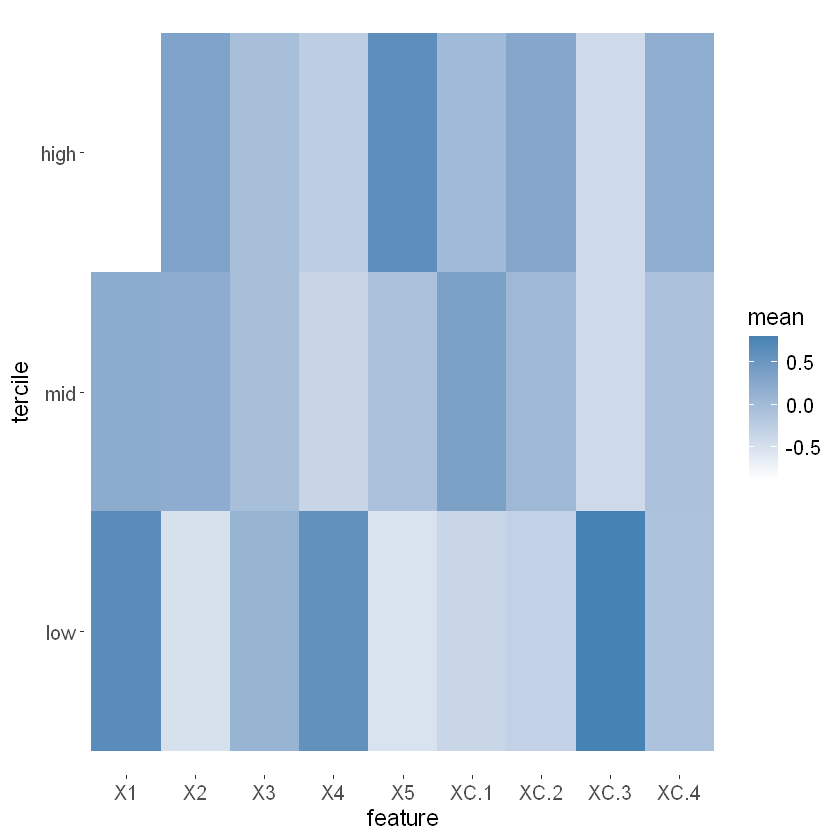

In [26]:
#
# Visualize school-level covariates by treatment heterogeneity
#

school.X.std = scale(school.X)
school.tercile = cut(school.pred,
                     breaks = c(-Inf, quantile(school.pred, c(1/3, 2/3)), Inf))
school.tercile.mat = model.matrix(~ school.tercile + 0)
school.means = diag(1 / colSums(school.tercile.mat)) %*% t(school.tercile.mat) %*% as.matrix(school.X.std)

MM = max(abs(school.means))
HC = heat.colors(21)
school.col = apply(school.means, 1:2, function(aa) HC[1 + round(20 * (0.5 + aa))])

DF.plot = data.frame(tercile=rep(factor(1:3, labels=c("low", "mid", "high")), 9), mean=as.numeric(school.means),
                     feature = factor(rbind(colnames(school.X), colnames(school.X), colnames(school.X))))

ggplot(data = DF.plot, aes(x = feature, y = tercile, fill = mean)) +
    geom_tile() + scale_fill_gradient(low = "white", high = "steelblue") +
    theme(axis.text = element_text(size=12), axis.title = element_text(size=14),
          legend.title = element_text(size=14), legend.text = element_text(size=12)) +
    theme(panel.background = element_blank())
ggsave("tercile_plot.pdf", width = 8, height = 4.5, dpi = 120)

mean(school.X$XC.3)
mean(school.X$XC.3[as.numeric(school.tercile) == 1])

In [27]:
#
# CATE by school
#

ord = order(order(school.pred))
school.sort = ord[school.id]

pdf("school_boxplot.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(tau.hat.noclust ~ school.sort, xaxt = "n",
        xlab = "school", ylab = "estimated CATE")
points(1:76, sort(school.pred), col = 4, pch = 16)
legend("topleft", c("school mean CATE", "CATE w/o clustering"), pch = c(16, 1), col = c(4, 1), cex = 1.5)
par = pardef
dev.off()

png 
  2